In [76]:
mp = 0.93827                                                           #proton mass
pz = 158.0                                                             #beam momentum
root_s = (2 * mp * (mp + (mp ** 2 + pz ** 2) ** 0.5)) ** 0.5           #sqrt(s)
norm = 3.141593 * root_s / 2                                           #normalization in new coordinats
sig_trig = 28.23                                                       #trigger cross section

In [77]:
import sys

sys.path.insert(0, '/opt/homebrew/Cellar/pythia/8.309/lib')

import pythia8

In [78]:
N_events = int(1e7) 
ids = [-211, 211, -321, 321]

In [79]:
import os
from tqdm import tqdm

In [80]:
def gen_data(exp_name, conf_file, tune_pp=14, n_events=int(1e6), additional_instructions={}):

    try:
    
        os.mkdir(f'gen_data/{exp_name}')
    
    except FileExistsError: pass

    pythia = pythia8.Pythia("", False)

    files = dict(zip(ids, [open(f'gen_data/{exp_name}/{id}.csv', 'w') for id in ids]))

    for id in ids: files[id].write('pT,xF,E\n')

    pythia.readFile(conf_file)
    pythia.readString(f'Tune:pp = {tune_pp}')
        
    for inst, val in  additional_instructions.items():
            
        pythia.readString(f'{inst} = {val}')

    boost = pythia8.Vec4()
    boost.pz(mp * ((1 + (pz / mp) ** 2) ** 0.5 - 1) ** 0.5)
    boost.e((boost.pz() ** 2 + mp ** 2) ** 0.5)

    pythia.init()

    for _ in tqdm(range(n_events)):

        if not pythia.next(): continue
        
        entries = pythia.event.size()

        for j in range(entries):

            particle = pythia.event[j]

            id = particle.id()
            
            if abs(int(id)) == 211 or abs(int(id)) == 321:

                P_mu = particle.p()

                P_mu.bstback(boost)

                pT = P_mu.pT()
                xF = 2 * P_mu.pz() / root_s
                E = P_mu.e()

                files[id].write(f'{pT},{xF},{E}\n')

    sig_total = pythia.getSigmaTotal()

    sigma_file = open(f'gen_data/{exp_name}/sigma_total.txt', 'w')
    sigma_file.write(f'{sig_total}')
    sigma_file.close()

    for id in ids: files[id].close()

In [96]:
params_file = open('params.txt', 'r')

In [97]:
params = {
    'SigmaDiffractive:dampen': 'on',
    'SpaceShower:phiIntAsym': 'on',
    'SpaceShower:phiPolAsym': 'on',
    'SpaceShower:rapidityOrder': 'on',
    'SpaceShower:rapidityOrderMPI': 'on',
    'SpaceShower:samePTasMPI': 'off',
    'TimeShower:dampenBeamRecoil': 'on',
    'TimeShower:phiPolAsym': 'on'
}

baseline = len(params)

for line in params_file.readlines():

    param = line.split('|')

    params[param[1].replace(" ", "")] = float(param[3])

In [83]:
for i in range(baseline, len(params)):

    gen_data(exp_name=i,
         conf_file='../exp_data/na49/config.cmnd', 
         tune_pp=1,
         additional_instructions=dict(list(params.items())[:i]),
         n_events=N_events)

100%|██████████| 10000000/10000000 [33:07<00:00, 5030.85it/s] 


In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [85]:
sig_totals = {}

for i in range(len(params)):

    sigma_file = open(f'gen_data/{i}/sigma_total.txt', 'r')
    sig_total = float(sigma_file.readline())
    sigma_file.close()

    sig_totals[i] = sig_total

In [86]:
bins_file = open('../exp_data/na49/binning.bin', 'r')

In [87]:
bins = []

for num, line in enumerate(bins_file.readlines()):

    if num % 2 == 0:
        
        a = line.split('|')

        for bin in a:

            bin = bin.replace('(', '').replace(')', '').replace(' ', '')
            bins.append(list(map(float, bin.split(','))))

bins = np.array(bins)

bins_file.close()

In [88]:
def xsect_calc(data, sig_total):

    xsect = []
    err = []

    for bin in bins:

        xF = bin[0]
        pT = bin[1]

        dxF = bin[2]
        dpT = bin[3]

        mask_for_bin = (data['xF'] > xF - dxF / 2) * (data['xF'] < xF + dxF / 2) * (data['pT'] > pT - dpT / 2) * (data['pT'] < pT + dpT / 2)

        dn = data[mask_for_bin]['E'].size

        dp3 = dxF * 2 * pT * dpT

        E = data[mask_for_bin]['E']

        xsect.append((E * (sig_total / N_events) * (dn / dp3) / norm).mean())
        err.append((E * (sig_total / N_events) * (dn / dp3) / norm).std())

    xsect = np.where(np.isnan(xsect), 0, xsect)
    err = np.where(np.isnan(err), 0, err)

    return xsect, err

In [89]:
def calc_metric(func, xsect, err, ref):

    res = []

    for num, bin in enumerate(bins):

        mask = (ref['xF'] == bin[0]) * (ref['pT'] == bin[1])

        if sum(mask) != 0:

            res.append(func(y_hat=xsect[num], y=ref['xsect'][mask].values[0],
                            y_hat_err=err[num], y_err=ref['error'][mask].values[0]))

    return np.where(np.isnan(res), 0, res)

In [90]:
def chi_square(y_hat, y, y_hat_err=None, y_err=None):

    return (y_hat - y) ** 2 / (y_hat_err ** 2 + y_err ** 2)

In [102]:
metrics = {}

for i in range(baseline, len(params)):

    metrics[i] = []

    sigma_file = open(f'gen_data/{i}/sigma_total.txt', 'r')
    sig_total = float(sigma_file.readline())
    sigma_file.close()

    for id in ids:

        data = pd.read_csv(f'gen_data/{i}/{id}.csv')
        ref = pd.read_csv(f'../exp_data/na49/{id}.csv')

        xsect, err = xsect_calc(data, sig_total)

        res = calc_metric(chi_square, xsect, err, ref)

        metrics[i].append(np.mean(res))

/var/folders/9j/cllsf0815jl9bm0yjv_8cm400000gn/T/ipykernel_19508/3748578070.py:3: RuntimeWarning: invalid value encountered in double_scalars
  return (y_hat - y) ** 2 / (y_hat_err ** 2 + y_err ** 2)
/var/folders/9j/cllsf0815jl9bm0yjv_8cm400000gn/T/ipykernel_19508/3748578070.py:3: RuntimeWarning: invalid value encountered in double_scalars
  return (y_hat - y) ** 2 / (y_hat_err ** 2 + y_err ** 2)
/var/folders/9j/cllsf0815jl9bm0yjv_8cm400000gn/T/ipykernel_19508/3748578070.py:3: RuntimeWarning: invalid value encountered in double_scalars
  return (y_hat - y) ** 2 / (y_hat_err ** 2 + y_err ** 2)
/var/folders/9j/cllsf0815jl9bm0yjv_8cm400000gn/T/ipykernel_19508/3748578070.py:3: RuntimeWarning: invalid value encountered in double_scalars
  return (y_hat - y) ** 2 / (y_hat_err ** 2 + y_err ** 2)
/var/folders/9j/cllsf0815jl9bm0yjv_8cm400000gn/T/ipykernel_19508/3748578070.py:3: RuntimeWarning: invalid value encountered in double_scalars
  return (y_hat - y) ** 2 / (y_hat_err ** 2 + y_err ** 2)


In [109]:
x = list(metrics.keys())
y = np.array(list(metrics.values())).sum(axis=1)

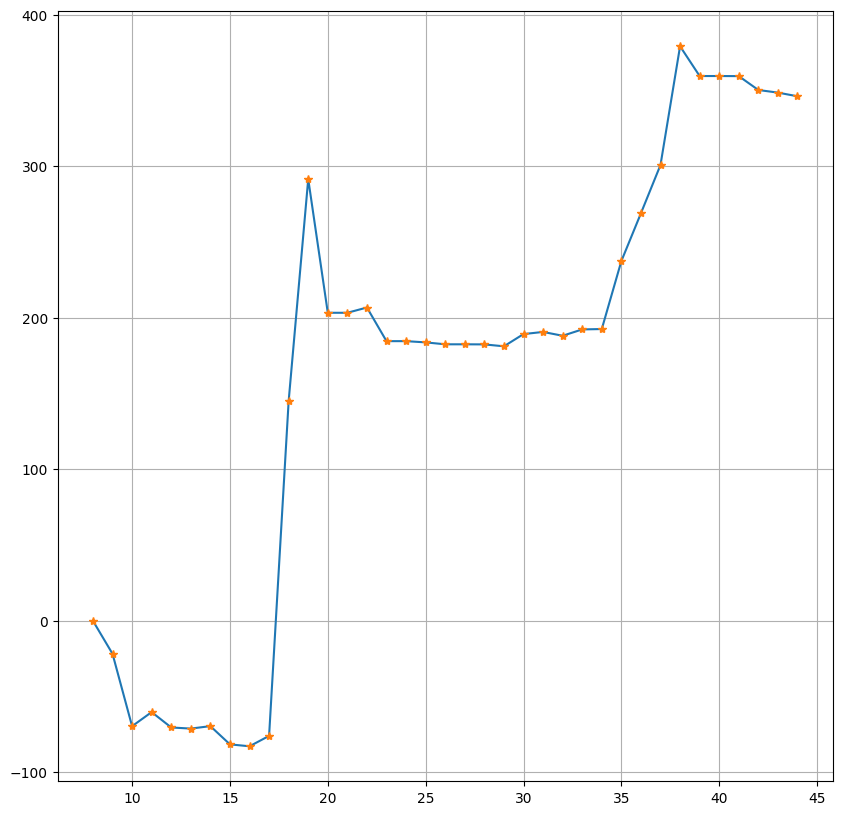

In [120]:
plt.figure(figsize=(10, 10))

plt.plot(x, y - y[0])
plt.errorbar(x, y - y[0], fmt='*')

plt.grid()

plt.show()

In [138]:
print('Important parametrs:\n\n',
      '\n'.join(np.array(list(params.keys()))[[18, 35, 36, 37, 38]]), sep='')

Important parametrs:

MultipartonInteractions:expPow
StringPT:sigma
StringZ:aExtraDiquark
StringZ:aLund
StringZ:bLund
